In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.linear_model import LinearRegression 
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import VarianceThreshold




## Opis podataka
train.csv i test.csv:

- date: Datum prodaje 
- store_nbr: Jedinstveni identifikacioni broj prodavnice (npr., prodavnica 5, prodavnica 10)
- family: Kategorija proizvoda (npr., AUTOMOTIVE, BABY_CARE, BEAUTY, BEVERAGES)
- sales: Ukupna prodaja u novčanoj vrednosti za datu kategoriju proizvoda u određenoj prodavnici na određeni dan. Može biti razlomljen broj jer se neki proizvodi mogu prodavati na meru (npr. 1.5 kg sira). Ovo je ciljna promenljiva koju treba predvideti za test skup podataka.
- onpromotion: Broj artikala u okviru date kategorije proizvoda koji su bili na promociji u određenoj prodavnici na određeni dan.

stores.csv:

- store_nbr: Jedinstveni identifikacioni broj prodavnice (povezuje se sa train.csv i test.csv)
- city: Grad u kojem se nalazi prodavnica
- state: Država u kojoj se nalazi prodavnica (u ovom slučaju, Ekvador)
- type: Tip prodavnice (A, B, C, D, E)
- cluster: Grupa sličnih prodavnica 

oil.csv:

- date: Datum
- dcoilwtico: Dnevna cena nafte (West Texas Intermediate Crude Oil)

holidays_events.csv:

- date: Datum praznika ili događaja
- type: Tip praznika ili događaja (Praznik, Događaj, Dodatni praznik, Most, Radni dan, Transfer)
- locale: Da li je praznik lokalni (samo u jednom regionu) ili nacionalni (cela država)
- locale_name: Naziv regiona ako je praznik lokalni
- description: Opis praznika ili događaja
- transferred: Da li je praznik pomeren na drugi dan (True/False)


In [2]:
train = pd.read_csv("data/train.csv", parse_dates=['date'])
stores = pd.read_csv("data/stores.csv")
oil = pd.read_csv("data/oil.csv", parse_dates=['date'])
holidays = pd.read_csv("data/holidays_events.csv", parse_dates=['date'])
transactions = pd.read_csv("data/transactions.csv", parse_dates=['date'])
holidays = holidays.drop(columns=["description", "transferred"], axis= 1)

test = pd.read_csv("data/test.csv", parse_dates=['date'])
sample_sub = pd.read_csv("data/sample_submission.csv")

In [3]:
date_range = pd.date_range(start=oil['date'].min(), end=oil['date'].max())
date_df = pd.DataFrame(date_range, columns=['date'])

merged_df = pd.merge(date_df, oil, on='date', how='left')

merged_df['dcoilwtico'].interpolate(method='linear', inplace=True)

rolling_mean = merged_df['dcoilwtico'].rolling(window=3, min_periods=1).mean()
merged_df['dcoilwtico'].fillna(rolling_mean, inplace=True)

oil = merged_df

In [4]:
train["test"] = 0
test["test"] = 1

data = pd.concat([train, test], axis=0)

data["date"] = pd.to_datetime(data["date"])
data

,id,date,store_nbr,family,sales,onpromotion,test
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0
1,1,2013-01-01,1,BABY CARE,0.000,0,0
2,2,2013-01-01,1,BEAUTY,0.000,0,0
3,3,2013-01-01,1,BEVERAGES,0.000,0,0
4,4,2013-01-01,1,BOOKS,0.000,0,0
...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,1
28509,3029397,2017-08-31,9,PRODUCE,NaN,1,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,1


In [5]:
data = data.groupby(['date', 'store_nbr','test'], as_index=False)[['sales', 'onpromotion']].sum()


In [7]:
data = data.merge(holidays, on="date", how="left")
data = data.merge(stores, on="store_nbr", how="left")
data = data.merge(oil, on="date", how="left")
data = data.merge(transactions, on=["date", "store_nbr"], how="left")
data = data.set_index(["store_nbr", "date"])
data = data.drop(index="2013-01-01", level=1)
data

,,test,sales,onpromotion,type_x,locale,locale_name,city,state,type_y,cluster,dcoilwtico,transactions
store_nbr,date,,,,,,,,,,,,
1,2013-01-02,0,7417.148,0,NaN,NaN,NaN,Quito,Pichincha,D,13,93.140,2111.000
2,2013-01-02,0,10266.719,0,NaN,NaN,NaN,Quito,Pichincha,D,13,93.140,2358.000
3,2013-01-02,0,24060.348,0,NaN,NaN,NaN,Quito,Pichincha,D,8,93.140,3487.000
4,2013-01-02,0,10200.084,0,NaN,NaN,NaN,Quito,Pichincha,D,9,93.140,1922.000
5,2013-01-02,0,10598.619,0,NaN,NaN,NaN,Santo Domingo,Santo Domingo de los Tsachilas,D,4,93.140,1903.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,2017-08-31,1,0.000,199,NaN,NaN,NaN,Ambato,Tungurahua,A,14,47.260,NaN
51,2017-08-31,1,0.000,176,NaN,NaN,NaN,Guayaquil,Guayas,A,17,47.260,NaN
52,2017-08-31,1,0.000,201,NaN,NaN,NaN,Manta,Manabi,A,11,47.260,NaN


In [8]:
data.to_csv("data/data.csv")

In [9]:
data_ = data.copy().reset_index()

train = data_[data_["test"] == 0]
test = data_[data_["test"] == 1]

train["date"] = pd.to_datetime(train["date"])
train["day_of_week"] = train["date"].dt.day_of_week
train["day_of_year"] = train["date"].dt.dayofyear
train["day_of_month"] = train["date"].dt.day
train["month"] = train["date"].dt.month
train["quarter"] = train["date"].dt.quarter
train["year"] = train["date"].dt.year

In [11]:
data_ = data.copy().reset_index()
grouped_data = data_.groupby(["store_nbr"])

In [12]:
data_["date"] = pd.to_datetime(data_["date"])
data_["day_of_week"] = data_["date"].dt.day_of_week
data_["day_of_year"] = data_["date"].dt.dayofyear
data_["day_of_month"] = data_["date"].dt.day
data_["month"] = data_["date"].dt.month
data_["quarter"] = data_["date"].dt.quarter
data_["year"] = data_["date"].dt.year

In [14]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93366 entries, 0 to 93365
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store_nbr     93366 non-null  int64         
 1   date          93366 non-null  datetime64[ns]
 2   test          93366 non-null  int64         
 3   sales         93366 non-null  float64       
 4   onpromotion   93366 non-null  int64         
 5   type_x        15228 non-null  object        
 6   locale        15228 non-null  object        
 7   locale_name   15228 non-null  object        
 8   city          93366 non-null  object        
 9   state         93366 non-null  object        
 10  type_y        93366 non-null  object        
 11  cluster       93366 non-null  int64         
 12  dcoilwtico    93366 non-null  float64       
 13  transactions  85006 non-null  float64       
 14  day_of_week   93366 non-null  int64         
 15  day_of_year   93366 non-null  int64 

In [15]:
data_.head()

,store_nbr,date,test,sales,onpromotion,type_x,locale,locale_name,city,state,type_y,cluster,dcoilwtico,transactions,day_of_week,day_of_year,day_of_month,month,quarter,year
0,1,2013-01-02,0,7417.148,0,NaN,NaN,NaN,Quito,Pichincha,D,13,93.140,2111.000,2,2,2,1,1,2013
1,2,2013-01-02,0,10266.719,0,NaN,NaN,NaN,Quito,Pichincha,D,13,93.140,2358.000,2,2,2,1,1,2013
2,3,2013-01-02,0,24060.348,0,NaN,NaN,NaN,Quito,Pichincha,D,8,93.140,3487.000,2,2,2,1,1,2013
3,4,2013-01-02,0,10200.084,0,NaN,NaN,NaN,Quito,Pichincha,D,9,93.140,1922.000,2,2,2,1,1,2013
4,5,2013-01-02,0,10598.619,0,NaN,NaN,NaN,Santo Domingo,Santo Domingo de los Tsachilas,D,4,93.140,1903.000,2,2,2,1,1,2013


In [16]:
data_.isna().sum()

store_nbr           0
date                0
test                0
sales               0
onpromotion         0
type_x          78138
locale          78138
locale_name     78138
city                0
state               0
type_y              0
cluster             0
dcoilwtico          0
transactions     8360
day_of_week         0
day_of_year         0
day_of_month        0
month               0
quarter             0
year                0
dtype: int64

In [17]:
data_['transactions'] = data_['transactions'].fillna(0) 
data_['type_x']= data_['type_x'].fillna(0) 
data_['locale']= data_['locale'].fillna(0) 
data_['locale_name']= data_['locale_name'].fillna(0) 

In [18]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93366 entries, 0 to 93365
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store_nbr     93366 non-null  int64         
 1   date          93366 non-null  datetime64[ns]
 2   test          93366 non-null  int64         
 3   sales         93366 non-null  float64       
 4   onpromotion   93366 non-null  int64         
 5   type_x        93366 non-null  object        
 6   locale        93366 non-null  object        
 7   locale_name   93366 non-null  object        
 8   city          93366 non-null  object        
 9   state         93366 non-null  object        
 10  type_y        93366 non-null  object        
 11  cluster       93366 non-null  int64         
 12  dcoilwtico    93366 non-null  float64       
 13  transactions  93366 non-null  float64       
 14  day_of_week   93366 non-null  int64         
 15  day_of_year   93366 non-null  int64 

In [45]:
data_.describe()

,store_nbr,test,sales,onpromotion,cluster,dcoilwtico,transactions,day_of_week,day_of_year,day_of_month,month,quarter,year
count,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000,93366.000
mean,27.500,0.009,11744.877,87.755,8.481,67.621,1545.125,3.009,174.541,15.738,6.242,2.420,2014.864
std,15.586,0.096,9989.321,120.126,4.650,25.637,1042.051,2.000,102.761,8.799,3.362,1.092,1.355
min,1.000,0.000,0.000,0.000,1.000,26.190,0.000,0.000,1.000,1.000,1.000,1.000,2013.000
25%,14.000,0.000,5565.589,0.000,4.000,46.380,917.000,1.000,87.000,8.000,3.000,1.000,2014.000
50%,27.500,0.000,9277.672,26.000,8.500,53.190,1326.000,3.000,172.000,16.000,6.000,2.000,2015.000
75%,41.000,0.000,15012.331,157.000,13.000,95.617,1970.000,5.000,258.000,23.000,9.000,3.000,2016.000
max,54.000,1.000,136457.427,2233.000,17.000,110.620,8359.000,6.000,366.000,31.000,12.000,4.000,2017.000


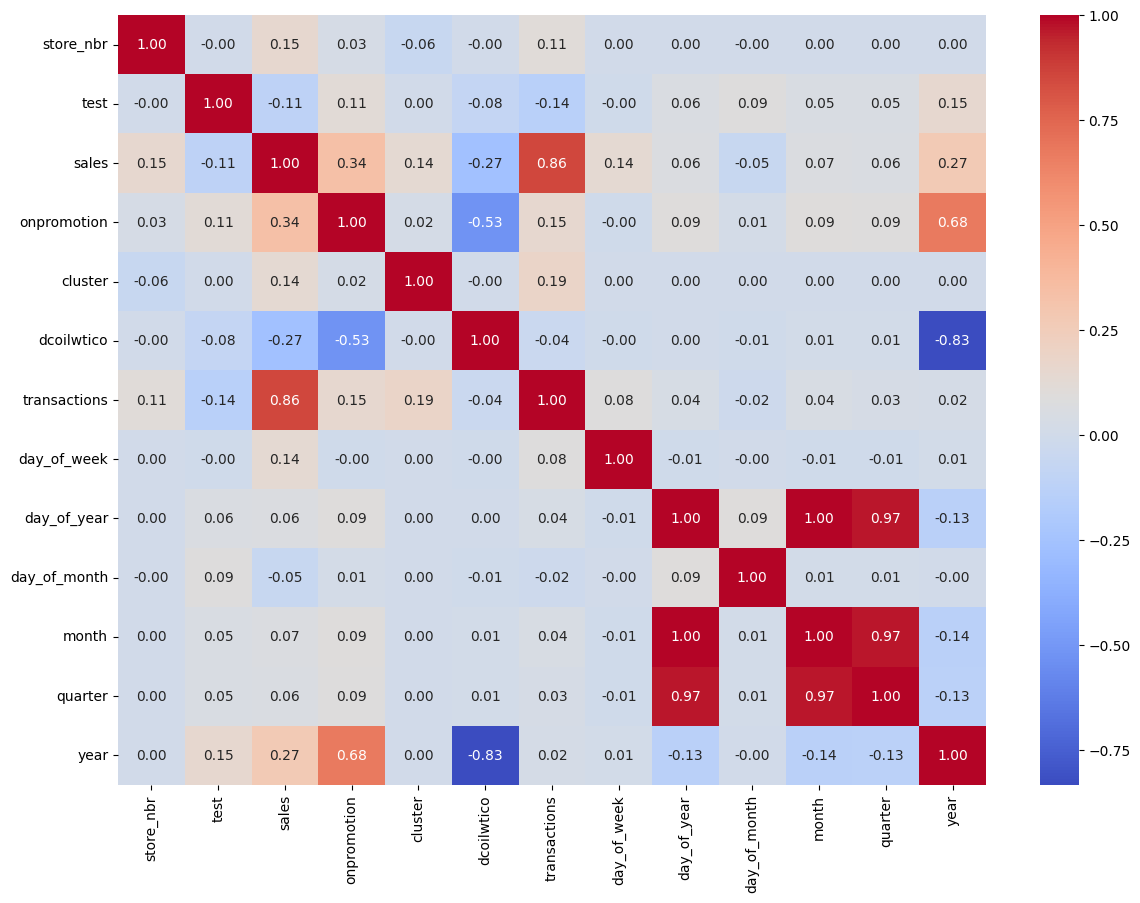

In [19]:
corr = data_.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [20]:
df = pd.get_dummies(data_)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93366 entries, 0 to 93365
Data columns (total 93 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   store_nbr                                   93366 non-null  int64         
 1   date                                        93366 non-null  datetime64[ns]
 2   test                                        93366 non-null  int64         
 3   sales                                       93366 non-null  float64       
 4   onpromotion                                 93366 non-null  int64         
 5   cluster                                     93366 non-null  int64         
 6   dcoilwtico                                  93366 non-null  float64       
 7   transactions                                93366 non-null  float64       
 8   day_of_week                                 93366 non-null  int64         
 9   day_of

In [22]:
df.to_csv('data/data_prepared.csv')

In [23]:
import pandas as pd 
df = pd.read_csv('data/data_prepared.csv', index_col=0)
# int_columns = df.select_dtypes(include=['int']).columns 
# df[int_columns] = df[int_columns].astype('uint8')

In [24]:
df.set_index('date', inplace=True)

In [25]:
df.head()

,store_nbr,test,sales,onpromotion,cluster,dcoilwtico,transactions,day_of_week,day_of_year,day_of_month,...,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_y_A,type_y_B,type_y_C,type_y_D,type_y_E
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,0,7417.148,0,13,93.140,2111.000,2,2,2,...,0,1,0,0,0,0,0,0,1,0
2013-01-02,2,0,10266.719,0,13,93.140,2358.000,2,2,2,...,0,1,0,0,0,0,0,0,1,0
2013-01-02,3,0,24060.348,0,8,93.140,3487.000,2,2,2,...,0,1,0,0,0,0,0,0,1,0
2013-01-02,4,0,10200.084,0,9,93.140,1922.000,2,2,2,...,0,1,0,0,0,0,0,0,1,0
2013-01-02,5,0,10598.619,0,4,93.140,1903.000,2,2,2,...,0,0,0,1,0,0,0,0,1,0


In [26]:
df_models =  df[df['test'] == 0].copy() 

df_models.drop('test', axis=1, inplace=True)

split_index = int(df_models.shape[0]*0.8)

df_train = df_models.iloc[:split_index]
df_test = df_models.iloc[split_index:]

X_train, X_test = df_train.drop('sales', axis=1), df_test.drop('sales', axis=1)
y_train, y_test = df_train['sales'], df_test['sales']

## Model training

In [27]:
def train_test_models(rf: RandomForestRegressor, lr: LinearRegression, xgb: XGBRegressor):
    rf = rf

    rf.fit(X_train, y_train) 
    y_pred_rf = rf.predict(X_test)

    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    lr = lr

    lr.fit(X_train, y_train)

    y_pred_lr = lr.predict(X_test)

    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    r2_lr= r2_score(y_test, y_pred_lr)

    xgb = xgb
    xgb.fit(X_train, y_train)

    y_pred_xgb = xgb.predict(X_test)

    rmse_xgb=  np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    r2_xgb= r2_score(y_test, y_pred_xgb)

    return y_pred_rf, y_pred_lr, y_pred_xgb, pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'XGBoost'],
    'RMSE': [rmse_rf, rmse_lr, rmse_xgb],
    'MAE': [mae_rf, mae_lr, mae_xgb],
    'R^2': [r2_rf, r2_lr, r2_xgb]
    })


In [28]:
y_pred_rf, y_pred_lr, y_pred_xgb,comparison_df = train_test_models(RandomForestRegressor(random_state=27, n_jobs=-1), LinearRegression(), XGBRegressor(n_jobs=-1))
comparison_df.head()

,Model,RMSE,MAE,R^2
0,Random Forest,3222.175,1955.000,0.920
1,Linear Regression,5032.348,3770.979,0.805
2,XGBoost,3177.995,1875.613,0.922


### Hyperparameter optimization

In [29]:

models = {
    "Linear regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=27, n_jobs=-1),
    "XGBoost": XGBRegressor(n_jobs=-1)
}

params = {
    "Random Forest":
    {
        'n_estimators': list(range(1,300)),
        'max_depth':list(range(2,100)),
        'min_samples_split': list(range(1,50)),
        'min_samples_leaf':list(range(2,15))
    },
    "XGBoost":
    {
        'n_estimators': list(range(1, 300)),
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': list(range(2,15)),
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
    },
    "Linear regression":
    {
        'fit_intercept': [True, False]
    }
}

best_estimators = {}
for model_name, model in models.items():
    print(f"Optimizing hyperparameters for {model_name}...")
    rand_search = RandomizedSearchCV(model, params[model_name], n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=27, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    best_estimators[model_name] = rand_search.best_estimator_
    print(f"Best parameters for {model_name}: {rand_search.best_params_}")


for model_name, model in best_estimators.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    print(f"{model_name} Cross-Validation root mean squared error: {np.sqrt(-cv_scores.mean()):.4f} (± {np.sqrt(cv_scores.std()):.4f})")

Optimizing hyperparameters for Linear regression...
Best parameters for Linear regression: {'fit_intercept': True}
Optimizing hyperparameters for Random Forest...
Best parameters for Random Forest: {'n_estimators': 171, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 45}
Optimizing hyperparameters for XGBoost...
Best parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 211, 'max_depth': 6, 'learning_rate': 0.2}
Linear regression Cross-Validation root mean squared error: 4341.3192 (± 2467.7220)
Random Forest Cross-Validation root mean squared error: 4169.0795 (± 3241.2169)
XGBoost Cross-Validation root mean squared error: 3658.1139 (± 2977.5096)


In [47]:
lr_optimal = LinearRegression(fit_intercept=True)
rf_optimal = RandomForestRegressor(n_estimators= 100, min_samples_split= 31, min_samples_leaf= 2, max_depth= 82, random_state=27, n_jobs=-1)
xgb_optimal= XGBRegressor(subsample=0.9, n_estimators = 141, max_depth=4, learning_rate = 0.3, n_jobs=-1)

# lr_optimal = LinearRegression(fit_intercept=True)
# rf_optimal = RandomForestRegressor(n_estimators= 234, min_samples_split= 6, min_samples_leaf= 3, max_depth= 29, random_state=27, n_jobs=-1)
# xgb_optimal= XGBRegressor(subsample=0.7, n_estimators = 192, max_depth=6, learning_rate = 0.3, n_jobs=-1)

# lr_optimal = LinearRegression(fit_intercept=True)
# rf_optimal = RandomForestRegressor(n_estimators= 171, min_samples_split= 8, min_samples_leaf= 5, max_depth= 45, random_state=27, n_jobs=-1)
# xgb_optimal= XGBRegressor(subsample=0.7, n_estimators = 211, max_depth=6, learning_rate = 0.2, n_jobs=-1)


y_pred_rf, y_pred_lr, y_pred_xgb, comparison_df_optimal = train_test_models(rf_optimal, lr_optimal, xgb_optimal)
comparison_df_optimal.head()

,Model,RMSE,MAE,R^2
0,Random Forest,3286.119,1995.151,0.917
1,Linear Regression,5032.348,3770.979,0.805
2,XGBoost,3161.902,1954.744,0.923


In [31]:
comparison_df.head()

,Model,RMSE,MAE,R^2
0,Random Forest,3222.175,1955.000,0.920
1,Linear Regression,5032.348,3770.979,0.805
2,XGBoost,3177.995,1875.613,0.922


### Plotting results

In [32]:
df_plot = pd.DataFrame()

df_plot['y_test'] = y_test 
df_plot['y_pred_rf'] = y_pred_rf
df_plot['y_pred_lr'] = y_pred_xgb
df_plot['y_pred_xgb'] = y_pred_lr

In [33]:
df_plot.head()

,y_test,y_pred_rf,y_pred_lr,y_pred_xgb
date,,,,
2016-09-12,6227.350,7371.990,7099.939,9620.104
2016-09-12,7783.631,7474.279,8432.160,7651.304
2016-09-12,14936.037,15422.036,15899.789,17420.580
2016-09-12,0.000,387.269,400.150,3105.622
2016-09-12,3027.342,3445.203,4264.194,5335.943


In [34]:
df_plot.reset_index(inplace=True)
df_plot_aggregated = df_plot.groupby('date').sum().reset_index()

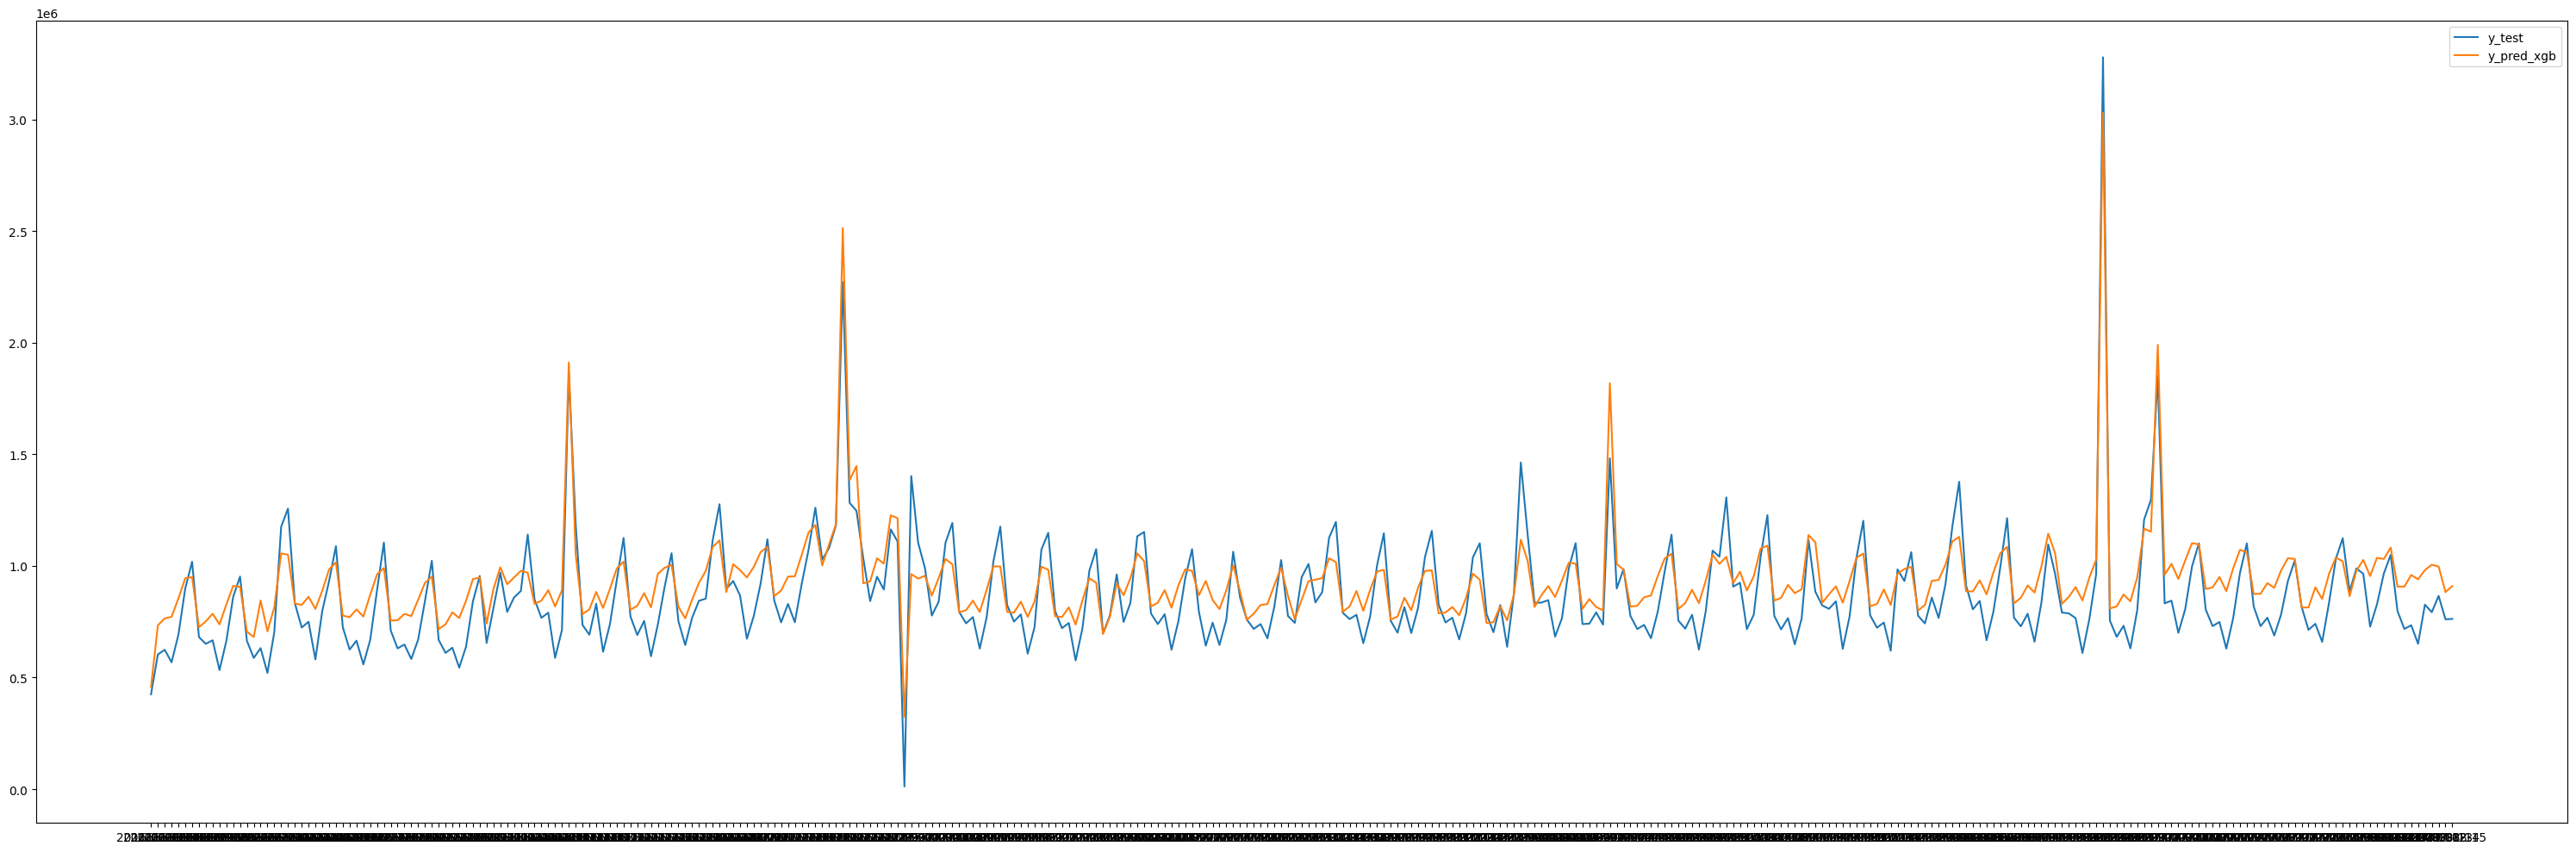

In [35]:
plt.figure(figsize=(30,10))

plt.plot(df_plot_aggregated['date'], df_plot_aggregated['y_test'], label="y_test")
plt.plot(df_plot_aggregated['date'], df_plot_aggregated['y_pred_xgb'], label="y_pred_xgb")

plt.legend()
plt.tight_layout()

plt.show()

In [36]:
df_plot['date'] = pd.to_datetime(df_plot['date'])

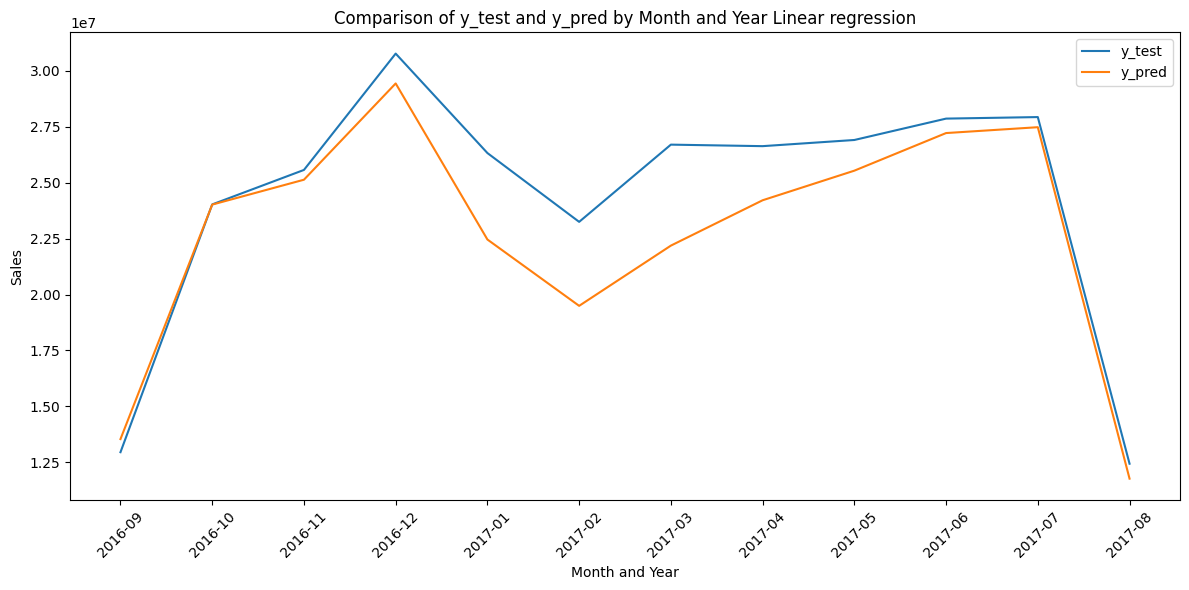

In [37]:
df_plot['month_year'] = df_plot['date'].dt.to_period('M')

df_plot_aggregated = df_plot.groupby('month_year').sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_plot_aggregated['month_year'].dt.strftime('%Y-%m'), df_plot_aggregated['y_test'], label="y_test")
plt.plot(df_plot_aggregated['month_year'].dt.strftime('%Y-%m'), df_plot_aggregated['y_pred_lr'], label="y_pred")

plt.xlabel('Month and Year')
plt.ylabel('Sales')
plt.title('Comparison of y_test and y_pred by Month and Year Linear regression')
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout()
plt.show()

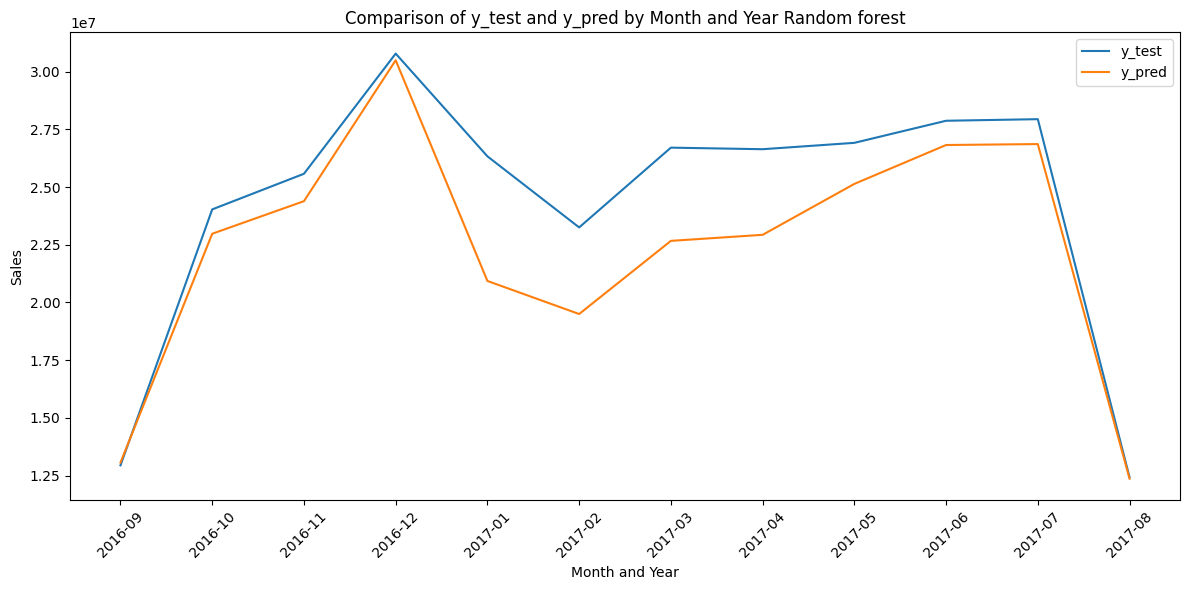

In [38]:
df_plot['month_year'] = df_plot['date'].dt.to_period('M')

df_plot_aggregated = df_plot.groupby('month_year').sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_plot_aggregated['month_year'].dt.strftime('%Y-%m'), df_plot_aggregated['y_test'], label="y_test")
plt.plot(df_plot_aggregated['month_year'].dt.strftime('%Y-%m'), df_plot_aggregated['y_pred_rf'], label="y_pred")

plt.xlabel('Month and Year')
plt.ylabel('Sales')
plt.title('Comparison of y_test and y_pred by Month and Year Random forest')
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout()
plt.show()

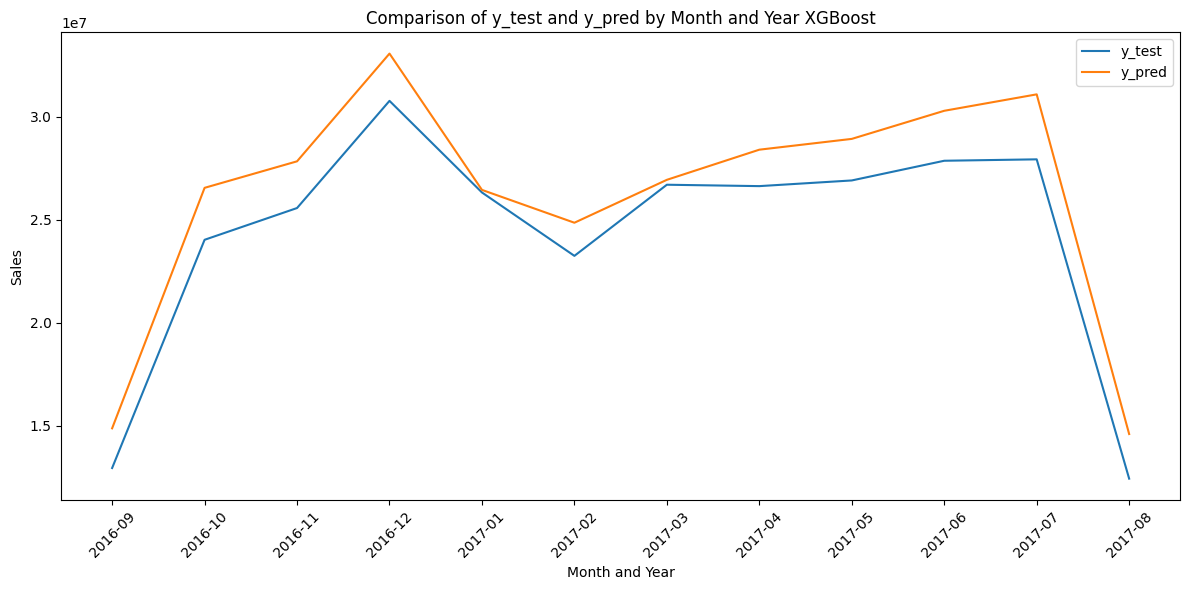

In [39]:
df_plot['month_year'] = df_plot['date'].dt.to_period('M')

df_plot_aggregated = df_plot.groupby('month_year').sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_plot_aggregated['month_year'].dt.strftime('%Y-%m'), df_plot_aggregated['y_test'], label="y_test")
plt.plot(df_plot_aggregated['month_year'].dt.strftime('%Y-%m'), df_plot_aggregated['y_pred_xgb'], label="y_pred")

plt.xlabel('Month and Year')
plt.ylabel('Sales')
plt.title('Comparison of y_test and y_pred by Month and Year XGBoost')
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout()
plt.show()

### Variance threshold feature selection

In [40]:
selector = VarianceThreshold(threshold=0.1)
X_sel_train = selector.fit_transform(df_train.drop('sales', axis=1))
X_sel_test = selector.fit_transform(df_test.drop('sales', axis=1))

In [41]:
lr_optimal.fit(X_sel_train, y_train)
y_pred_lr = lr_optimal.predict(X_sel_test)

rmse_lr_opt= np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr_opt = mean_absolute_error(y_test, y_pred_lr)
r2_lr_opt= r2_score(y_test, y_pred_lr)

rf_optimal.fit(X_sel_train, y_train) 
y_pred_rf = rf_optimal.predict(X_sel_test)

rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf)
r2_rf_opt = r2_score(y_test, y_pred_rf)


xgb_optimal.fit(X_sel_train, y_train)
y_pred_xgb = xgb_optimal.predict(X_sel_test)

rmse_xgb_opt=  np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb_opt = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb_opt= r2_score(y_test, y_pred_xgb)


comparison_df_optimal_sel = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'XGBoost'],
    'RMSE': [rmse_rf_opt, rmse_lr_opt, rmse_xgb_opt],
    'MAE': [mae_rf_opt, mae_lr_opt, mae_xgb_opt],
    'R^2': [r2_rf_opt, r2_lr_opt, r2_xgb_opt]
})

comparison_df_optimal_sel.head()

,Model,RMSE,MAE,R^2
0,Random Forest,3264.626,1980.722,0.918
1,Linear Regression,5163.687,3924.267,0.795
2,XGBoost,2869.036,1794.925,0.937


### Feature importance selection

In [42]:
rf_optimal.fit(X_train, y_train) 
y_pred_rf = rf_optimal.predict(X_test)

rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf)
r2_rf_opt = r2_score(y_test, y_pred_rf)

comparison_df_optimal = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'XGBoost'],
    'RMSE': [rmse_rf_opt, rmse_lr_opt, rmse_xgb_opt],
    'MAE': [mae_rf_opt, mae_lr_opt, mae_xgb_opt],
    'R^2': [r2_rf_opt, r2_lr_opt, r2_xgb_opt]
})

comparison_df_optimal.head()




,Model,RMSE,MAE,R^2
0,Random Forest,3286.119,1995.151,0.917
1,Linear Regression,5163.687,3924.267,0.795
2,XGBoost,2869.036,1794.925,0.937


In [43]:
importance_rf = rf_optimal.feature_importances_
# df_selected = df_train[importance_rf.columns]
selected_features = df_train.drop('sales', axis=1).columns[importance_rf > np.mean(importance_rf)]

X_selected_train = df_train.drop('sales', axis=1)[selected_features]
X_selected_test = df_test.drop('sales', axis=1)[selected_features]

rf_optimal.fit(X_selected_train, y_train) 
y_pred_rf = rf_optimal.predict(X_selected_test)

rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf)
r2_rf_opt = r2_score(y_test, y_pred_rf)

In [44]:
print(rmse_rf_opt)
print(mae_rf_opt)
print(r2_rf_opt)

3267.996953083621
1986.3184361369497
0.9178852304601566


### Isključenje izvedenih promenljivih

In [64]:
data_ = pd.read_csv("data/data.csv")

train = data_[data_["test"] == 0]
test = data_[data_["test"] == 1]

data_['transactions'] = data_['transactions'].fillna(0) 
data_['type_x']= data_['type_x'].fillna(0) 
data_['locale']= data_['locale'].fillna(0) 
data_['locale_name']= data_['locale_name'].fillna(0) 

data_['date'] = pd.to_datetime(data_['date'])
data_.set_index('date', inplace=True)
data_ = pd.get_dummies(data_)

In [67]:
df_models =  data_[data_['test'] == 0].copy() 

df_models.drop('test', axis=1, inplace=True)

split_index = int(df_models.shape[0]*0.8)

df_train = df_models.iloc[:split_index]
df_test = df_models.iloc[split_index:]

X_train, X_test = df_train.drop('sales', axis=1), df_test.drop('sales', axis=1)
y_train, y_test = df_train['sales'], df_test['sales']

In [68]:
lr_optimal = LinearRegression(fit_intercept=True)
rf_optimal = RandomForestRegressor(n_estimators= 100, min_samples_split= 31, min_samples_leaf= 2, max_depth= 82, random_state=27, n_jobs=-1)
xgb_optimal= XGBRegressor(subsample=0.9, n_estimators = 141, max_depth=4, learning_rate = 0.3, n_jobs=-1)

y_pred_rf, y_pred_lr, y_pred_xgb, comparison_df_optimal = train_test_models(rf_optimal, lr_optimal, xgb_optimal)
comparison_df_optimal.head()

,Model,RMSE,MAE,R^2
0,Random Forest,4037.570,2314.908,0.875
1,Linear Regression,5071.601,3114.562,0.802
2,XGBoost,3987.467,2482.331,0.878


Prophet, ARIMA, Sarimax, RNN, LSTM 